In [1]:
!pip install bitmex
!pip install python-binance
!pip install keras_multi_head
!pip install requests --upgrade
!pip install sktime
!pip install keras-self-attention
!pip install tsmoothie

In [2]:
import keras
from keras import Sequential
from keras.metrics import RootMeanSquaredError
from keras.layers import Conv1D, Dropout, AveragePooling1D, LSTM, RepeatVector, TimeDistributed, Dense
#from keras.layers import Sequential, Conv1D, Dropout, AveragePooling1D, LSTM, RepeatVector, TimeDistributed, Dense, RootMeanSquaredError

In [3]:
# IMPORTS
import requests
import tsmoothie
import matplotlib.pyplot as plt
import pandas as pd
import math
import os.path
import time
from bitmex import bitmex
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
from keras_multi_head import MultiHeadAttention
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
from keras import backend as K
from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.detrend import Detrender
from keras_self_attention import SeqSelfAttention

### API
bitmex_api_key = 'QJztZ3vF61eSlyYdDe1xnCrL'    #Enter your own API-key here
bitmex_api_secret = 'iV05s1WvMdagCcerBaW-OglyS5DR41KEM7ti148vG67-lwA7' #Enter your own API-secret here
binance_api_key = 'buEUMq3Qo5LaTwCOKl4vFJG1fe9kCmJtOtXOaPlpr7wgtF3iwXiVC3yKPFLTviyO'    #Enter your own API-key here
binance_api_secret = 'lpHoAXrM2n42H9W2cOlnQUD1zckp1v6PiaCjQuLdgoPrCJ4jaBA8NGHxDd4OodSA' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 1000
bitmex_client = bitmex(test=False, api_key=bitmex_api_key, api_secret=bitmex_api_secret)
#binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new


def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'RC2YY8JWEUDMY6IW'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    print(raw_df)
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df


#def get_all_binance(symbol, kline_size, save = False):
#    filename = '%s-%s-data.csv' % (symbol, kline_size)
#    if os.path.isfile(filename): data_df = pd.read_csv(filename)
#    else: data_df = pd.DataFrame()
#    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
#    delta_min = (newest_point - oldest_point).total_seconds()/60
#    available_data = math.ceil(delta_min/binsizes[kline_size])
#    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
#    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
#    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
#    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
#    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
#    if len(data_df) > 0:
#        temp_df = pd.DataFrame(data)
#        data_df = data_df.append(temp_df)
#    else: data_df = data
#    data_df.set_index('timestamp', inplace=True)
#    if save: data_df.to_csv(filename)
#    print('All caught up..!')
#    return data_df

def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm_notebook(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

/usr/local/lib/python3.10/dist-packages/swagger_spec_validator/validator20.py:49: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  warnings.warn(


In [4]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [5]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') <= 1e-3:
            self.model.stop_training = True

In [6]:
import numpy as np
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother

def getOutliers(stock, exchange, dict_output, lookback, startdate, enddate):
  outlier_points = []

  symbol = stock
  crypto = stock + '-' + exchange
  #yfin.pdr_override()
  data = pdr.get_data_yahoo(crypto, start=startdate, end=enddate)
  df = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
  df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
  eps = 1e-9
  df['Open'] = df['Open'].astype('float32') + eps
  df['High'] = df['High'].astype('float32') + eps
  df['Low'] = df['Low'].astype('float32') + eps
  df['Close'] = df['Close'].astype('float32') + eps
  df['Adj Close'] = df['Adj Close'].astype('float32') + eps
  df['Volume'] = df['Volume'].astype('float32') + eps

  if len(df) < 20:
    return

  data = df['Adj Close'].values.reshape(1, -1)

  # operate smoothing
  smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
  smoother.smooth(data)

  # generate intervals
  low, up = smoother.get_intervals('prediction_interval')

  points = smoother.data[0]
  up_points = up[0]
  low_points = low[0]

  for i in range(len(points)-1, 0, -1):
      current_point = points[i]
      current_up = up_points[i]
      current_low = low_points[i]
      if current_point > current_up or current_point < current_low:
          outlier_points.append(i)
          print(f'found an outlier value: {current_point}')

  overall_points = list(set(list(range(len(df)))) - set(outlier_points))
  print(overall_points)

In [7]:
def getFuturePrices(stock, exchange, dict_output, lookback, startdate, enddate):
  outlier_points = []
  symbol = stock
  crypto = stock + '-' + exchange
  #yfin.pdr_override()
  #data = pdr.get_data_yahoo(crypto, start=startdate, end=enddate)
  data = yfin.download(
    tickers = crypto,
    period = "max",
    interval = "15m"
    )
  df = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
  df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
  eps = 1e-9
  df['Open'] = df['Open'].astype('float32') + eps
  df['High'] = df['High'].astype('float32') + eps
  df['Low'] = df['Low'].astype('float32') + eps
  df['Close'] = df['Close'].astype('float32') + eps
  df['Adj Close'] = df['Adj Close'].astype('float32') + eps
  df['Volume'] = df['Volume'].astype('float32') + eps

  one_hot1 = pd.get_dummies(pd.DatetimeIndex(df.index).month.astype('int'))
  one_hot2 = pd.get_dummies(pd.DatetimeIndex(df.index).day.astype('int'))
  # Drop column B as it is now encoded
  # Join the encoded df
  df = df.reset_index()
  df = pd.concat([df, one_hot1, one_hot2], axis=1)
  if(len(df) < lookback):
    return(dict_output)
  df = df.drop("Datetime", axis=1)
  print(df)

  data = df['Adj Close'].values.reshape(1, -1)

  # operate smoothing
  smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
  smoother.smooth(data)

  # generate intervals
  low, up = smoother.get_intervals('prediction_interval')

  points = smoother.data[0]
  up_points = up[0]
  low_points = low[0]

  for i in range(len(points)-1, 0, -1):
      current_point = points[i]
      current_up = up_points[i]
      current_low = low_points[i]
      if current_point > current_up or current_point < current_low:
        for j in range(-1,1,1):
          outlier_points.append(i+j)

  overall_points = list(set(list(range(len(df)))) - set(outlier_points))
  overall_df = df[df.reset_index().index.isin(overall_points)]
  print(overall_df)

  compare_df = pd.DataFrame()
  compare_df['Actual'] = df[-120:]['Adj Close'].tolist()
  print(compare_df)

  train = overall_df[:(-1*lookback)-121]
  scalers={}
  for i in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
      scaler = Pipeline([('log', LogTransformer()), ('scaler', StandardScaler()), ('max', MinMaxScaler(feature_range=(-1,1)))]) #MinMaxScaler()
      s_s = scaler.fit(df[:(-1*lookback)-121][i].values.reshape(-1,1))
      s_s = scaler.transform(train[i].values.reshape(-1,1))
      s_s=np.reshape(s_s,len(s_s))
      scalers['scaler_'+ i] = scaler
      train[i]=s_s
  test = overall_df[(-1*lookback)-121:-120]
  for i in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
      scaler = scalers['scaler_'+i]
      s_s = scaler.transform(test[i].values.reshape(-1,1))
      s_s=np.reshape(s_s,len(s_s))
      scalers['scaler_'+i] = scaler
      test[i]=s_s


  n_past = lookback
  n_future = 1
  n_features = 6+len(one_hot1.columns)+len(one_hot2.columns)

  X_train, y_train = split_series(train.values, n_past, n_future)
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
  y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
  X_test, y_test = split_series(test.values, n_past, n_future)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
  y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

  X_train = np.asarray(X_train).astype('float32')
  y_train = np.asarray(y_train).astype('float32')
  X_test = np.asarray(X_test).astype('float32')
  y_test = np.asarray(y_test).astype('float32')

  model_e1d1 = Sequential()
  model_e1d1.add(Conv1D(filters=256, kernel_size=3,    # Standard 128
                                strides=1, padding='causal',
                                activation="relu",
                                input_shape=(None, n_features)))
  model_e1d1.add(Dropout(0.2))
  model_e1d1.add(AveragePooling1D(pool_size=3))
  model_e1d1.add(Conv1D(filters=256, kernel_size=3,    # Standard 128
                                strides=1, padding='causal',
                                activation="relu",
                                input_shape=(None, n_features)))
  model_e1d1.add(Dropout(0.2))
  model_e1d1.add(AveragePooling1D(pool_size=3))
  model_e1d1.add(LSTM(1000, dropout=0.2, recurrent_dropout=0.2, input_shape=(n_past, n_features)))
  model_e1d1.add(RepeatVector(n_future))
  model_e1d1.add(MultiHeadAttention(
      head_num=5,
      name='Multi-Head',
  ))
  model_e1d1.add(LSTM(1000, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model_e1d1.add(TimeDistributed(Dense(n_features, activation='linear')))
  #model_e1d1.load_weights("original_dataset_power_new_2.h5")
  model_e1d1.summary()

  x = 1000
  y = 2e-3
  z = 1
  #optimizer = keras.optimizers.Adamax(lr=x*y*z)
  model_checkpoint_callback_e1d1 = tf.keras.callbacks.ModelCheckpoint(filepath="original_dataset_power_new_2.weights.h5", save_weights_only=True, monitor='root_mean_squared_error',save_best_only=True)
  callback = keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', min_delta=0.001, patience=10000)
  reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: y * z ** x)
  model_e1d1.compile(optimizer='Adam', loss='mse', metrics=[RootMeanSquaredError()])
  history_e1d1=model_e1d1.fit(X_train,y_train,shuffle=False,epochs=200,validation_data=(X_test,y_test),batch_size=256,verbose=1,callbacks=[callback, reduce_lr, model_checkpoint_callback_e1d1])


  test2 = X_test
  final_values_non_spike = np.zeros(shape=(120,6+len(one_hot1.columns)+len(one_hot2.columns)))
  for i in range(120):
    pred_e1d1=model_e1d1.predict(test2)
    for j in range(lookback):
      if j != (lookback-1):
        test2[0][j] = test2[0][j+1]
      else:
        test2[0][j] = pred_e1d1[0]

    final_values_non_spike[i] = pred_e1d1[0]


  final_values_non_spike = np.array([final_values_non_spike])

  pred_e1d1 = final_values_non_spike
  for index,i in enumerate(df.columns):
    if i in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
      scaler = scalers['scaler_'+i]
      pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
      y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
      y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

  final_df = pd.DataFrame(pred_e1d1[0])

  months = [i for i in range(len(one_hot1.columns))]
  days = [i for i in range(len(one_hot2.columns))]
  days_of_week = [i for i in range(2)]
  final_df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] + months + days
  print(final_df)

  compare_df['Predicted'] = final_df['Adj Close'].tolist()
  print(compare_df)

  dict_output[crypto] = (df['Adj Close'].iloc[-1], final_df['Adj Close'].max())

  plt.plot(list(range(120)), compare_df['Actual'].tolist())
  plt.plot(list(range(120)), compare_df['Predicted'].tolist())
  plt.title('title')
  plt.ylabel('ylabel')
  plt.xlabel('xlabel')
  plt.legend()
  plt.show()

  print(dict_output)
  #return(dict_output)

  spike_points = []
  for i in outlier_points:
    for j in range(-20,20,1):
      spike_points.append(i+j)

  spike_points = list(set(spike_points))
  overall_points = spike_points
  overall_df = df[df.reset_index().index.isin(overall_points)]


  train = overall_df[:(-1*lookback)-1]
  for i in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
      scaler = scalers['scaler_'+ i]
      s_s = scaler.transform(train[i].values.reshape(-1,1))
      s_s=np.reshape(s_s,len(s_s))
      scalers['scaler_'+ i] = scaler
      train[i]=s_s
  test = overall_df[(-1*lookback)-1:]
  for i in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
      sscaler = scalers['scaler_'+ i]
      s_s = scaler.transform(test[i].values.reshape(-1,1))
      s_s=np.reshape(s_s,len(s_s))
      scalers['scaler_'+i] = scaler
      test[i]=s_s

  n_past = lookback
  n_future = 1
  n_features = 6+len(one_hot1.columns) + len(one_hot2.columns)

  X_train, y_train = split_series(train.values, n_past, n_future)
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
  y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
  X_test, y_test = split_series(test.values, n_past, n_future)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
  y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

  X_train = np.asarray(X_train).astype('float32')
  y_train = np.asarray(y_train).astype('float32')
  X_test = np.asarray(X_test).astype('float32')
  y_test = np.asarray(y_test).astype('float32')

  # E1D1
  # n_features ==> no of features at each timestep in the data.
  #
  encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
  encoder_l1 = tf.keras.layers.LSTM(1500, dropout=0.2, recurrent_dropout=0.2, return_state=True)
  encoder_outputs1 = encoder_l1(encoder_inputs)
  encoder_states1 = encoder_outputs1[1:]
  decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
  decoder_inputs1 = MultiHeadAttention(head_num=5) (decoder_inputs)
  decoder_l1 = tf.keras.layers.LSTM(1500, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(decoder_inputs1, initial_state = encoder_states1)
  decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features, activation='linear'))(decoder_l1)
  model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
  model_e2d2.summary()

  reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
  model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
  history_e2d2=model_e1d1.fit(X_train,y_train,epochs=40,validation_data=(X_test,y_test),batch_size=256)


  final_values = final_values_non_spike[0]
  X_test, y_test = split_series(final_values[:31], n_past, n_future)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
  test2 = X_test
  for i in range(lookback):
    print("Called here")
    pred_e2d2=model_e2d2.predict(test2)
    for j in range(lookback):
      if j != (lookback-1):
        test2[0][j] = test2[0][j+1]
      else:
        test2[0][j] = pred_e2d2[0]

    final_values[i+lookback] = pred_e2d2[0]


  final_values = np.array([final_values])

  pred_e2d2 = final_values
  for index,i in enumerate(df.columns):
    if i in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
      scaler = scalers['scaler_'+i]
      pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
      y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
      y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])


  final_df = pd.DataFrame(pred_e2d2[0])

  months = [i for i in range(len(one_hot1.columns))]
  days = [i for i in range(len(one_hot2.columns))]
  days_of_week = [i for i in range(2)]
  final_df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] + months + days
  print(final_df)

  compare_df['Predicted'] = final_df['Adj Close'].tolist()
  print(compare_df)

  dict_output[crypto] = (df['Adj Close'].iloc[-1], final_df['Adj Close'].max())

  plt.plot(list(range(120)), compare_df['Actual'].tolist())
  plt.plot(list(range(120)), compare_df['Predicted'].tolist())
  plt.title('title')
  plt.ylabel('ylabel')
  plt.xlabel('xlabel')
  plt.legend()
  plt.show()

  print(dict_output)
  #return(dict_output)

  K.clear_session()
  del model_e1d1
  del model_e2d2



[*********************100%***********************]  1 of 1 completed


              Open          High           Low         Close     Adj Close  \
0     8.625528e-08  8.625528e-08  8.613004e-08  8.613004e-08  8.613004e-08   
1     8.617525e-08  8.630630e-08  8.617525e-08  8.630630e-08  8.630630e-08   
2     8.631332e-08  8.636552e-08  8.626549e-08  8.636552e-08  8.636552e-08   
3     8.641882e-08  8.641882e-08  8.633513e-08  8.637900e-08  8.637900e-08   
4     8.626876e-08  8.632660e-08  8.624897e-08  8.632660e-08  8.632660e-08   
...            ...           ...           ...           ...           ...   
5754  2.962238e-07  2.972876e-07  2.962238e-07  2.970656e-07  2.970656e-07   
5755  2.967699e-07  2.967699e-07  2.950631e-07  2.950631e-07  2.950631e-07   
5756  2.956309e-07  2.986630e-07  2.956309e-07  2.986630e-07  2.986630e-07   
5757  2.990153e-07  2.990153e-07  2.983086e-07  2.983086e-07  2.983086e-07   
5758  2.966414e-07  2.966414e-07  2.954335e-07  2.954335e-07  2.954335e-07   

            Volume     10     11     12      1  ...     22     

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
<ipython-input-7-2acd743933a4>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-7-2acd743933a4>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipyt

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, None, 256)           │          30,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 256)           │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, None, 256)           │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1000)                │       5,028,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 1000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Multi-Head (MultiHeadAttention)      │ (None, 1, 1000)             │       4,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 1000)             │       8,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 40)               │          40,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,303,880 (66.01 MB)

 Trainable params: 17,303,880 (66.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - loss: 0.1217 - root_mean_squared_error: 0.3478 - val_loss: 0.1225 - val_root_mean_squared_error: 0.3501 - learning_rate: 0.0020
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - loss: 0.1039 - root_mean_squared_error: 0.3217 - val_loss: 0.1232 - val_root_mean_squared_error: 0.3510 - learning_rate: 0.0020
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 0.0822 - root_mean_squared_error: 0.2863 - val_loss: 0.0929 - val_root_mean_squared_error: 0.3048 - learning_rate: 0.0020
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0872 - root_mean_squared_error: 0.2952 - val_loss: 0.1575 - val_root_mean_squared_error: 0.3968 - learning_rate: 0.0020
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0844 - root_mean_squared_error: 0.2902 - val_loss: 0.1565 - val_root_mean_squared_error: 0.3955 - learning_rate: 0.0020
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0758 - root_mean_squared

             Open          High           Low         Close     Adj Close  \
0    1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   
1    1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   
2    1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   
3    1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   
4    1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   
..            ...           ...           ...           ...           ...   
115  1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   
116  1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   
117  1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   
118  1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   
119  1.978147e-07  1.994812e-07  1.982015e-07  1.985642e-07  1.989476e-07   

       Volume         0         1         2         0  ...        21  \
0  

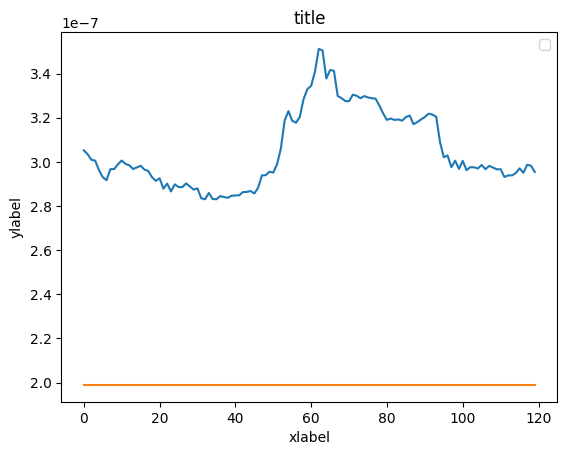

{'XEN-USD': (2.954335e-07, 1.989475957860883e-07)}


<ipython-input-7-2acd743933a4>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-7-2acd743933a4>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-7-2acd743933a4>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 30, 40)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 1500), (None,  │      9,246,000 │ input_layer_1[0][0]    │
│                           │ 1500), (None, 1500)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 1, 1500)        │              0 │ lstm_2[0][0]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 1500)        │      9,006,000 │ repeat_vector_1[0][0]  │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 1, 1500)        │     18,006,000 │ multi_head_attention[… │
│                           │                        │                │ lstm_2[0][1],          │
│                           │                        │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 1, 40)          │         60,040 │ lstm_3[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 36,318,040 (138.54 MB)

 Trainable params: 36,318,040 (138.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0510 - root_mean_squared_error: 0.2259 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2250
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0458 - root_mean_squared_error: 0.2140 - val_loss: 0.0517 - val_root_mean_squared_error: 0.2274
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0415 - root_mean_squared_error: 0.2036 - val_loss: 0.0533 - val_root_mean_squared_error: 0.2309
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - val_loss: 0.0543 - val_root_mean_squared_error: 0.2330
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0371 - root_mean_squared_error: 0.1925 - val_loss: 0.0541 - val_root_mean_squared_error: 0.2325
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0364 - root_mean_squared_error: 0.1908 - val_loss: 0.0530 - val_root_mean_squared_error: 0.2302
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0356 - roo

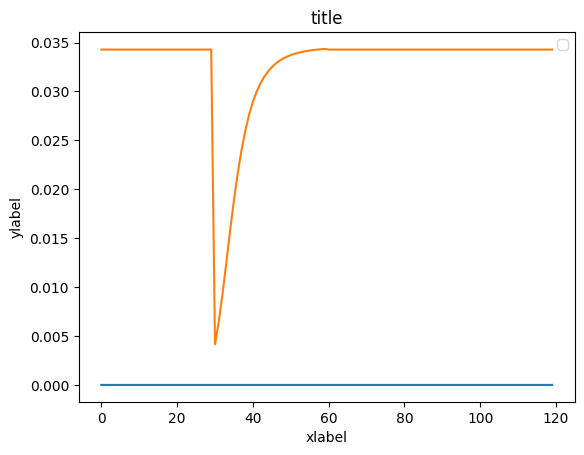

{'XEN-USD': (2.954335e-07, 0.0343436488138836)}


In [8]:
dict_output = {}
dict_output = getFuturePrices('XEN', 'USD', dict_output, 30, '2011-01-01', '2024-12-07')

In [ ]:
import requests

api_key = '6b1cf277-f71d-4408-9904-6666e5fce0e8'

cryptos = []
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'

for start in range(1, 20000, 5000):

    params = {
        'start': start,
        'limit': 5000,
    }

    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key
    }

    r = requests.get(url, params=params, headers=headers)
    data = r.json()

    for number, item in enumerate(data['data']):
        print(f"{start+number:4} | {item['symbol']:5} | {item['date_added'][:10]}")
        cryptos.append(item['symbol'])


ETHDOG


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ETHDOG-BTC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


ETHDOG


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ETHDOG-ETH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ETHDOG-USD']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


ETHDOG


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JOL-BTC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


JOL
JOL


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JOL-ETH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


JOL


[*********************100%***********************]  1 of 1 completed


          Open      High       Low     Close  Adj Close        Volume     10  \
0     0.000311  0.000311  0.000311  0.000311   0.000311  1.000000e-09   True   
1     0.000311  0.000311  0.000311  0.000311   0.000311  1.000000e-09   True   
2     0.000311  0.000311  0.000311  0.000311   0.000311  1.000000e-09   True   
3     0.000311  0.000311  0.000311  0.000311   0.000311  1.000000e-09   True   
4     0.000310  0.000310  0.000310  0.000310   0.000310  1.000000e-09   True   
...        ...       ...       ...       ...        ...           ...    ...   
5755  0.000514  0.000514  0.000514  0.000514   0.000514  1.000000e-09  False   
5756  0.000514  0.000514  0.000514  0.000514   0.000514  1.000000e-09  False   
5757  0.000514  0.000514  0.000514  0.000514   0.000514  1.000000e-09  False   
5758  0.000514  0.000514  0.000514  0.000514   0.000514  1.000000e-09  False   
5759  0.000514  0.000514  0.000514  0.000514   0.000514  1.000000e-09  False   

         11     12      1  ...     22  

<ipython-input-7-2acd743933a4>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-7-2acd743933a4>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-7-2acd743933a4>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, None, 256)           │          30,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 256)           │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, None, 256)           │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1000)                │       5,028,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 1000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Multi-Head (MultiHeadAttention)      │ (None, 1, 1000)             │       4,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 1000)             │       8,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 40)               │          40,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,303,880 (66.01 MB)

 Trainable params: 17,303,880 (66.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0944 - root_mean_squared_error: 0.3060 - val_loss: 0.0699 - val_root_mean_squared_error: 0.2645 - learning_rate: 0.0020
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1188 - root_mean_squared_error: 0.3416 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2139 - learning_rate: 0.0020
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1305 - root_mean_squared_error: 0.3555 - val_loss: 0.0752 - val_root_mean_squared_error: 0.2742 - learning_rate: 0.0020
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.1187 - root_mean_squared_error: 0.3391 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2277 - learning_rate: 0.0020
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.1113 - root_mean_squared_error: 0.3241 - val_loss: 0.0564 - val_root_mean_squared_error: 0.2374 - learning_rate: 0.0020
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0915 - root_mean_squared

         Open      High       Low     Close  Adj Close        Volume  \
0    0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   
1    0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   
2    0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   
3    0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   
4    0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   
..        ...       ...       ...       ...        ...           ...   
115  0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   
116  0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   
117  0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   
118  0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   
119  0.000501  0.000501  0.000501  0.000501   0.000501  1.115115e-09   

            0         1         2         0  ...        21        22  \
0   -0.000312  0.001244  0.998579  0.113429  ... -0.000029  0.0

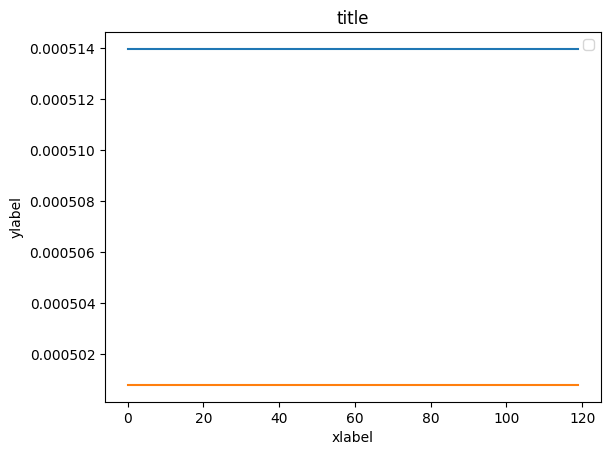

{'JOL-USD': (0.0005139758, 0.0005007915577768809)}


<ipython-input-7-2acd743933a4>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-7-2acd743933a4>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-7-2acd743933a4>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 30, 40)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 1500), (None,  │      9,246,000 │ input_layer_1[0][0]    │
│                           │ 1500), (None, 1500)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 1, 1500)        │              0 │ lstm_2[0][0]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 1500)        │      9,006,000 │ repeat_vector_1[0][0]  │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 1, 1500)        │     18,006,000 │ multi_head_attention[… │
│                           │                        │                │ lstm_2[0][1],          │
│                           │                        │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 1, 40)          │         60,040 │ lstm_3[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 36,318,040 (138.54 MB)

 Trainable params: 36,318,040 (138.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0273 - root_mean_squared_error: 0.1652 - val_loss: 0.0718 - val_root_mean_squared_error: 0.2679
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2623
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0247 - root_mean_squared_error: 0.1572 - val_loss: 0.0659 - val_root_mean_squared_error: 0.2567
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.0637 - val_root_mean_squared_error: 0.2524
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0240 - root_mean_squared_error: 0.1550 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2500
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0235 - root_mean_squared_error: 0.1533 - val_loss: 0.0618 - val_root_mean_squared_error: 0.2487
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0228 - root

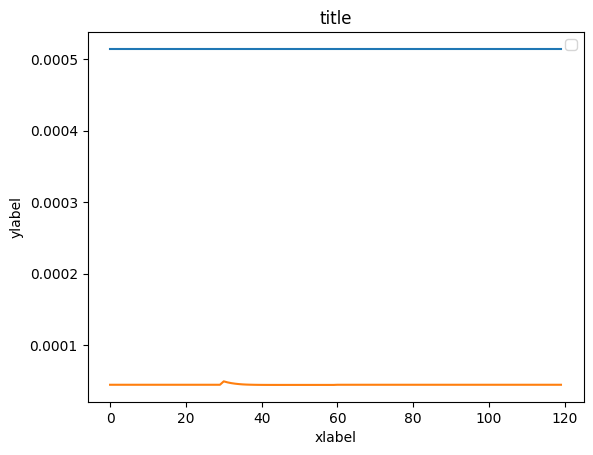

{'JOL-USD': (0.0005139758, 4.973356814681912e-05)}
HDV


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDV-BTC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


HDV


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDV-ETH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


HDV


[*********************100%***********************]  1 of 1 completed


          Open      High       Low     Close  Adj Close        Volume     10  \
0     0.000129  0.000129  0.000129  0.000129   0.000129  1.000000e-09   True   
1     0.000129  0.000129  0.000129  0.000129   0.000129  1.000000e-09   True   
2     0.000129  0.000129  0.000129  0.000129   0.000129  1.000000e-09   True   
3     0.000129  0.000129  0.000129  0.000129   0.000129  1.000000e-09   True   
4     0.000129  0.000129  0.000129  0.000129   0.000129  1.000000e-09   True   
...        ...       ...       ...       ...        ...           ...    ...   
5754  0.000134  0.000134  0.000134  0.000134   0.000134  1.000000e-09  False   
5755  0.000134  0.000134  0.000134  0.000134   0.000134  1.000000e+00  False   
5756  0.000134  0.000134  0.000134  0.000134   0.000134  6.100000e+01  False   
5757  0.000134  0.000134  0.000134  0.000134   0.000134  1.000000e-09  False   
5758  0.000134  0.000134  0.000134  0.000134   0.000134  1.000000e-09  False   

         11     12      1  ...     22  

<ipython-input-7-2acd743933a4>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-7-2acd743933a4>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-7-2acd743933a4>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, None, 256)           │          30,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 256)           │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, None, 256)           │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1000)                │       5,028,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 1000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Multi-Head (MultiHeadAttention)      │ (None, 1, 1000)             │       4,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 1000)             │       8,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 40)               │          40,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,303,880 (66.01 MB)

 Trainable params: 17,303,880 (66.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0632 - root_mean_squared_error: 0.2512 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2887 - learning_rate: 0.0020
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0665 - root_mean_squared_error: 0.2579 - val_loss: 0.0790 - val_root_mean_squared_error: 0.2810 - learning_rate: 0.0020
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0554 - root_mean_squared_error: 0.2354 - val_loss: 0.0799 - val_root_mean_squared_error: 0.2826 - learning_rate: 0.0020
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0568 - root_mean_squared_error: 0.2382 - val_loss: 0.0841 - val_root_mean_squared_error: 0.2900 - learning_rate: 0.0020
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0582 - root_mean_squared_error: 0.2411 - val_loss: 0.0852 - val_root_mean_squared_error: 0.2918 - learning_rate: 0.0020
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0626 - root_mean_squared_e

In [ ]:
import random

dict_output = {}

for i in range(100):
  n = random.randint(0,len(cryptos))
  for j in ['BTC', 'ETH', 'USD']:
    #n = i
    print(cryptos[n])
    dict_output = getFuturePrices(cryptos[n], j, dict_output, 30, '2011-01-01', '2024-12-08')

In [ ]:
dict_output

In [ ]:
dict_output

In [ ]:
dict_output = {}
dict_output = getFuturePrices('BLOB', 'USD', dict_output, 20, '2011-01-01', '2024-07-16')